## Star-Galaxy-Quasar Classification (Experiment 3) using Classical ML Algorithms. We are using only photometric features as input to our models.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import pickle

from sklearn.linear_model import SGDClassifier
# https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve, GridSearchCV


# 1. Create Train/Val/Test Sets

In [2]:
dnnx_sgq = np.load("/scratch/srinadb/Foundation/Dataset/Experiment3/dnnx_sgq_exp3.npy")
y_sgq = np.load("/scratch/srinadb/Foundation/Dataset/Experiment3/y_sgq_exp3.npy")
y_sgq = np.argmax(y_sgq, axis=1)
label_strings = ['GALAXY', 'QSO', 'STAR']

print('\n')
print(label_strings)




['GALAXY', 'QSO', 'STAR']


In [3]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

In [4]:
def plot_model_change(history,fname="output/time.pdf"):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'],label="Training Acc")
    plt.plot(history.history['val_accuracy'],label="Val Acc")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'],label="Training Loss")
    plt.plot(history.history['val_loss'],label="Val Loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(fname)
    plt.show()

# ML Algorithms

## DT Classifier

In [5]:
# Path to your saved model
model_path = "ml_pf_classifiers/EX1_SGQ_DT_Model.pkl"

# Load the model
with open(model_path, "rb") as f:
    DT = pickle.load(f)



In [6]:
y_test_pred_dt = DT.predict_proba(dnnx_sgq)
y_test_pred_dt = np.argmax(y_test_pred_dt, axis=1)

In [7]:
print(get_metrics(y_test_pred_dt, y_sgq, label_strings))

Identified 19452 correct labels out of 28532 labels
Accuracy: 0.6817608299453245
Precision: 0.7243156533387812
Recall: 0.6817560075715087
F1 Score: 0.6739090809269253
Labels are: ['GALAXY', 'QSO', 'STAR']
Confusion Matrix:
 [[9059  374   78]
 [3980 5175  355]
 [1682 2611 5218]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.62      0.95      0.75      9511
           1       0.63      0.54      0.59      9510
           2       0.92      0.55      0.69      9511

    accuracy                           0.68     28532
   macro avg       0.72      0.68      0.67     28532
weighted avg       0.72      0.68      0.67     28532

(array([    0,     1,     2, ..., 28487, 28501, 28514]), 0.6817608299453245, 0.7243156533387812, 0.6817560075715087, array([[9059,  374,   78],
       [3980, 5175,  355],
       [1682, 2611, 5218]]), '              precision    recall  f1-score   support\n\n           0       0.62      0.95      0.75      9511\n   

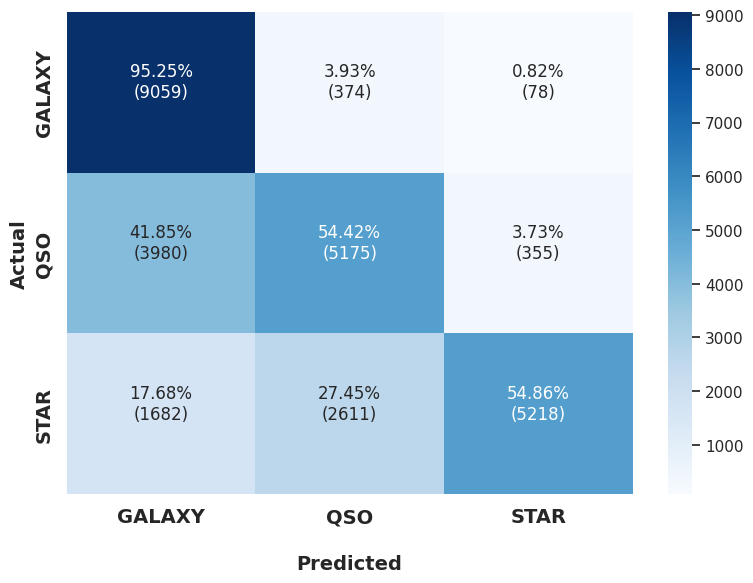

In [8]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_sgq, y_test_pred_dt)
cf_matrix_percentage = metrics.confusion_matrix(y_sgq, y_test_pred_dt, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(3,3)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("ml_pf_classifiers/EX3_SGQ_DT_CM.png")
plt.show()
plt.close()

## RF Classifier

In [9]:
# Path to your saved model
model_path = "ml_pf_classifiers/EX1_SGQ_RF_Model.pkl"

# Load the model
with open(model_path, "rb") as f:
    RF = pickle.load(f)



In [10]:
y_test_pred_rf = RF.predict_proba(dnnx_sgq)
y_test_pred_rf = np.argmax(y_test_pred_rf, axis=1)

In [11]:
print(get_metrics(y_test_pred_rf, y_sgq, label_strings))

Identified 20509 correct labels out of 28532 labels
Accuracy: 0.7188069535959625
Precision: 0.763666713532838
Recall: 0.7188022701258746
F1 Score: 0.7116124467115919
Labels are: ['GALAXY', 'QSO', 'STAR']
Confusion Matrix:
 [[9431   70   10]
 [3803 5565  142]
 [1331 2667 5513]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.65      0.99      0.78      9511
           1       0.67      0.59      0.62      9510
           2       0.97      0.58      0.73      9511

    accuracy                           0.72     28532
   macro avg       0.76      0.72      0.71     28532
weighted avg       0.76      0.72      0.71     28532

(array([    0,     1,     2, ..., 28444, 28474, 28481]), 0.7188069535959625, 0.763666713532838, 0.7188022701258746, array([[9431,   70,   10],
       [3803, 5565,  142],
       [1331, 2667, 5513]]), '              precision    recall  f1-score   support\n\n           0       0.65      0.99      0.78      9511\n     

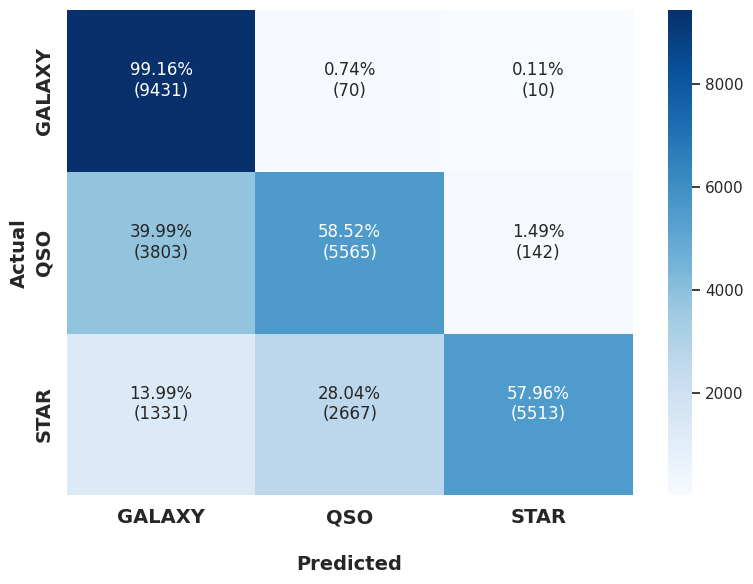

In [12]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()
cf_matrix = metrics.confusion_matrix(y_sgq, y_test_pred_rf)
cf_matrix_percentage = metrics.confusion_matrix(y_sgq, y_test_pred_rf, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(3,3)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("ml_pf_classifiers/EX3_SGQ_RF_CM.png")
plt.show()
plt.close()

## GBDT Classifier

In [13]:
# Path to your saved model
model_path = "ml_pf_classifiers/EX1_SGQ_GBDT_Model.pkl"

# Load the model
with open(model_path, "rb") as f:
    GBDT = pickle.load(f)



In [14]:
y_test_pred_gbdt = GBDT.predict_proba(dnnx_sgq)
y_test_pred_gbdt = np.argmax(y_test_pred_gbdt, axis=1)

In [15]:
print(get_metrics(y_test_pred_gbdt, y_sgq,label_strings))

Identified 21010 correct labels out of 28532 labels
Accuracy: 0.7363661853357634
Precision: 0.7735871182792827
Recall: 0.7363607132560697
F1 Score: 0.7304815161792438
Labels are: ['GALAXY', 'QSO', 'STAR']
Confusion Matrix:
 [[9444   57   10]
 [3761 5518  231]
 [1188 2275 6048]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79      9511
           1       0.70      0.58      0.64      9510
           2       0.96      0.64      0.77      9511

    accuracy                           0.74     28532
   macro avg       0.77      0.74      0.73     28532
weighted avg       0.77      0.74      0.73     28532

(array([    0,     1,     2, ..., 28480, 28481, 28484]), 0.7363661853357634, 0.7735871182792827, 0.7363607132560697, array([[9444,   57,   10],
       [3761, 5518,  231],
       [1188, 2275, 6048]]), '              precision    recall  f1-score   support\n\n           0       0.66      0.99      0.79      9511\n   

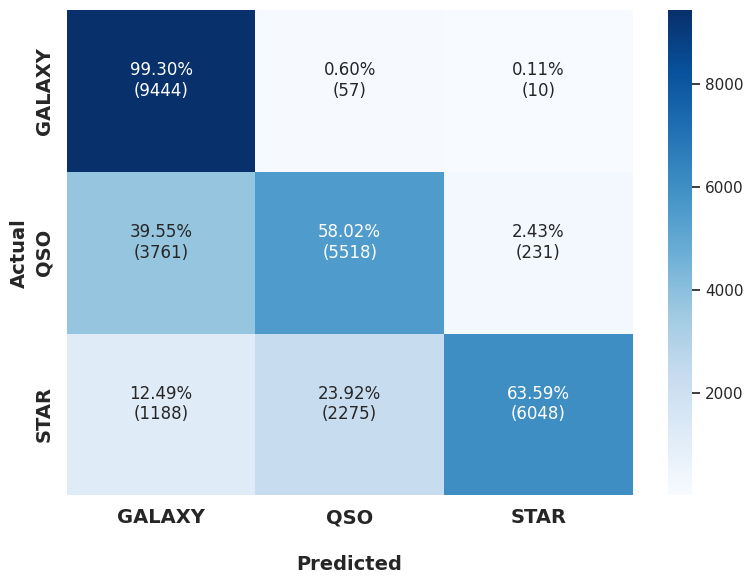

In [16]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#google_vignette
# fig = plt.figure()

cf_matrix = metrics.confusion_matrix(y_sgq, y_test_pred_gbdt)
cf_matrix_percentage = metrics.confusion_matrix(y_sgq, y_test_pred_gbdt, normalize='true')
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_percentage.flatten()]
labels = [f"{v1}\n({v2})\n" for v1, v2 in
          zip(group_percentages,group_counts)]
labels = np.asarray(labels).reshape(3,3)
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('\nPredicted', fontsize=14, weight='bold')
ax.set_ylabel('Actual', fontsize=14, weight='bold');
ax.xaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
ax.yaxis.set_ticklabels(['GALAXY', 'QSO', 'STAR'], fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("ml_pf_classifiers/EX3_SGQ_GBDT_CM.png")
plt.show()
plt.close()